In [1]:
import gudhi as gd
import numpy as np
from pprint import pprint
from scipy.spatial.distance import cdist
from preprolamu.io.storage import load_projected, load_embedding
from preprolamu.pipeline.universes import get_universe
from preprolamu.pipeline.embeddings import downsample_latent, project_PCA
from preprolamu.pipeline.persistence import compute_alpha_complex_persistence

In [2]:
def normalize_space(X, seed: int, diameter_iterations=1000):
    """
    Normalize a space based on an approximate diameter.
    """
    rng = np.random.default_rng(seed)
    subset = [rng.choice(len(X))]
    for _ in range(diameter_iterations - 1):
        distances = cdist([X[subset[-1]]], X).ravel()
        new_point = np.argmax(distances)
        subset.append(new_point)

    pairwise_distances = cdist(X[subset], X[subset])
    diameter = np.max(pairwise_distances)

    eps = 1e-8
    if not np.isfinite(diameter) or diameter < eps:
        print(
            f"[EMB] Computed diameter is non-finite or too small; defaulting to 1 (diameter={diameter})."
        )
        diameter = 1.0
    print(f"[EMB] Computed diameter: {diameter}")
    return X / diameter

In [3]:
import os
from pathlib import Path

def find_project_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    for p in [start, *start.parents]:
        if (p / "data").exists() and (p / "src").exists():
            return p
        if (p / "pyproject.toml").exists() or (p / ".git").exists():
            return p
    raise RuntimeError("Could not find project root (looked for data/src, pyproject.toml, or .git).")

root = find_project_root()
os.chdir(root)
print("CWD set to:", Path.cwd())
print("data exists:", (Path.cwd() / "data").exists())

CWD set to: c:\Users\u863593\OneDrive - Tilburg University\Documents\PhD\Sandbox_code\slurm_alpha_complex_landscapes
data exists: True


In [5]:
u = get_universe(85)
pprint(u)

Universe(dataset_id='NF-ToN-IoT-v3',
         scaling=<Scaling.QUANTILE: 'quantile'>,
         log_transform=<LogTransform.LOG1P: 'log1p'>,
         feature_subset=<FeatureSubset.ALL: 'all'>,
         duplicate_handling=<DuplicateHandling.DROP: 'drop'>,
         missingness=<Missingness.IMPUTE_MEDIAN: 'impute_median'>,
         seed=420,
         pca_dim=3,
         tda_config=TdaConfig(homology_dimensions=(0, 1, 2),
                              num_landscapes=5,
                              resolution=1000,
                              subsample_size=10000),
         id='ds-NF-ToN-IoT-v3_sc-quantile_log-log1p_fs-all_dup-drop_miss-impute_median_sd-420')


In [6]:
emb = load_embedding(u, split="test", force_recompute=False)

In [7]:
print(f"Original shape: {emb.shape}\n")
pprint(f"Original stats:\nmin={emb.min()}, max={emb.max()}, mean={emb.mean()}, std={emb.std()}, median={np.median(emb)}")

norm_emb = normalize_space(emb, seed=u.seed)
pprint(f"\nNormalized stats:\nmin={norm_emb.min()}, max={norm_emb.max()}, mean={norm_emb.mean()}, std={norm_emb.std()}, median={np.median(norm_emb)}")

Original shape: (5140825, 25)

('Original stats:\n'
 'min=-29.200664520263672, max=39.384300231933594, mean=-0.3391726315021515, '
 'std=6.529560089111328, median=-0.0037272777408361435')
[EMB] Computed diameter: 78.63469373613631
('\n'
 'Normalized stats:\n'
 'min=-0.3713458161132839, max=0.5008514481418355, mean=-0.004313269795464336, '
 'std=0.08303662932123687, median=-4.7399914258498414e-05')


In [8]:
type(norm_emb)

pprint({
    "min": norm_emb.min(),
    "max": norm_emb.max(),
    "mean": norm_emb.mean(),
    "std": norm_emb.std(),
    "median": np.median(norm_emb),
})
print("--"*20)
pprint({
    "min": emb.min(),
    "max": emb.max(),
    "mean": emb.mean(),
    "std": emb.std(),
    "median": np.median(emb),
})


{'max': np.float64(0.5008514481418355),
 'mean': np.float64(-0.004313269795464336),
 'median': np.float64(-4.7399914258498414e-05),
 'min': np.float64(-0.3713458161132839),
 'std': np.float64(0.08303662932123687)}
----------------------------------------
{'max': np.float32(39.3843),
 'mean': np.float32(-0.33917263),
 'median': np.float32(-0.0037272777),
 'min': np.float32(-29.200665),
 'std': np.float32(6.52956)}


In [9]:
pca_emb = project_PCA(norm_emb, n_components=3, seed=u.seed)
print(f"\nPCA projected shape: {pca_emb.shape}\n")
pprint({
    "min": pca_emb.min(),
    "max": pca_emb.max(),
    "mean": pca_emb.mean(),
    "std": pca_emb.std(),
    "median": np.median(pca_emb),
})


PCA projected shape: (5140825, 3)

{'max': np.float64(0.44112493751181964),
 'mean': np.float64(-1.2965075129196546e-15),
 'median': np.float64(-0.026480072733649683),
 'min': np.float64(-0.5144670827461217),
 'std': np.float64(0.18044074573991567)}


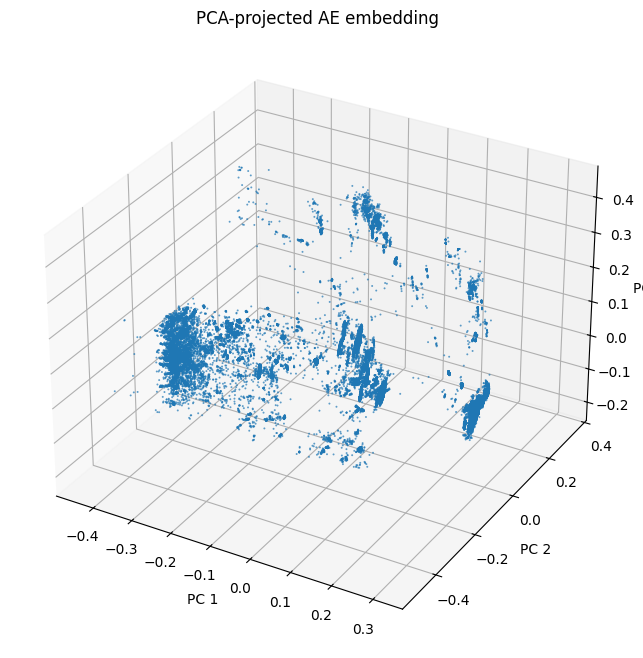

In [12]:
import matplotlib.pyplot as plt
down_emb = downsample_latent(pca_emb, target_size=100000, seed=u.seed)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    down_emb[:, 0],
    down_emb[:, 1],
    down_emb[:, 2],
    s=2.0,
    alpha=0.7,
    linewidths=0,
)
ax.set_title("PCA-projected AE embedding")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

plt.show()
plt.close(fig)



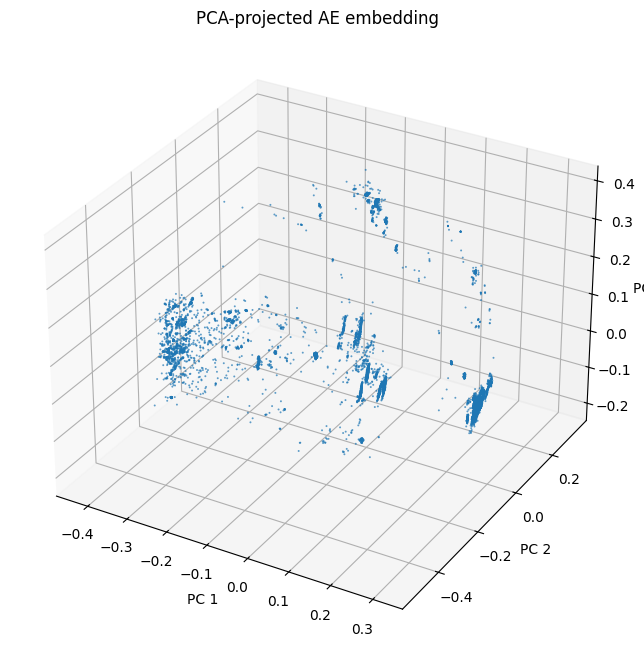

In [13]:

projection = load_projected(u, split="test")

projection_sample = downsample_latent(projection, target_size=10000, seed=u.seed)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    projection_sample[:, 0],
    projection_sample[:, 1],
    projection_sample[:, 2],
    s=2.0,
    alpha=0.7,
    linewidths=0,
)
ax.set_title("PCA-projected AE embedding")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

plt.show()
plt.close(fig)

In [14]:
per_dim = compute_alpha_complex_persistence(
            data=projection_sample,
            homology_dimensions=u.tda_config.homology_dimensions,
        )

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

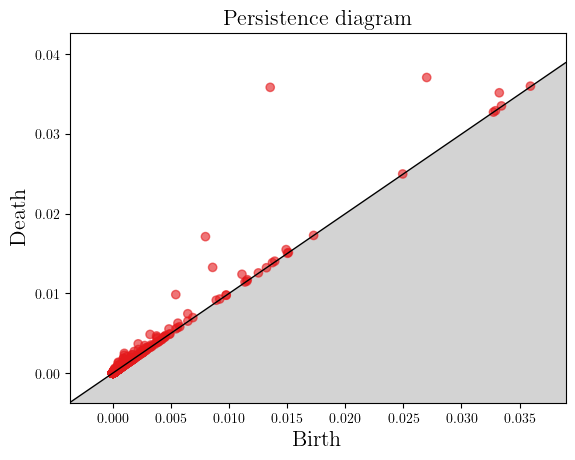

In [15]:
gd.plot_persistence_diagram(per_dim[1])

In [ ]:
gd.plot_persistence_barcode(per_dim[1])